# Mechanism determination with SVM

In this practical we will explore how to use a support vector machine to identify the type of focal mechanism of an earthquake from its moment tensor elements $\textbf{m}$. Our training data are based on moment tensor solutions for world wide seismicity between 1976 and 2017 dowloaded from the global CMT catalogue *https://www.globalcmt.org/CMTsearch.html*. The classification into different focal mechanisms for training purposes is performed with FMC:

Álvarez-Gómez, J.A. (2014) FMC: a one-liner Python program to man-
age, classify and plot focal mechanisms. Geophysical Research Ab-
stracts, Vol. 16, EGU2014-10887

As usual we first have to import a variety of python packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.multiclass import OneVsRestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import  OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import confusion_matrix

We then read in the data into a Pandas dataframe (https://pandas.pydata.org/docs/)

In [2]:
pdata = pd.read_csv('../Data/Momenttrain.out',sep=' ',header=0)

## Tasks
Have a look at the data. 
- What is in the dataset? Identify the different columns and relate them to the quantities in the lecture.
    - M is symmetric, therefore we only need 6 elements instead of 9
    - mrr = 1; mtt and mff
- Which quantities will be useful for the task?
    - Mechanism type

In [3]:
pdata.head()

,#Lon,Lat,Depth,mrr,mtt,mff,mrt,mrf,mtf,Exponent_(dyn-cm),X_position,Y_position,ID,Mechanism_type
0,183.04,-29.25,47.8,7.68,0.09,-7.77,1.39,4.52,-3.26,26,183.04,-29.25,M010176A,R
1,284.86,-13.42,85.4,-1.78,-0.59,2.37,-1.28,1.97,-2.90,24,284.86,-13.42,C010576A,N
2,159.50,51.45,15.0,1.10,-0.30,-0.80,1.05,1.24,-0.56,25,159.50,51.45,C010676A,R
3,167.81,-15.97,173.7,-1.70,2.29,-0.59,-2.33,-1.23,2.01,25,167.81,-15.97,C010976A,N
4,343.71,66.33,15.0,-0.51,-2.86,3.37,0.05,-0.78,-0.86,25,343.71,66.33,C011376A,SS


In [4]:
print(pdata)

        #Lon    Lat  Depth     mrr     mtt     mff     mrt     mrf     mtf  \
0     183.04 -29.25   47.8  7.6800  0.0900 -7.7700  1.3900  4.5200 -3.2600   
1     284.86 -13.42   85.4 -1.7800 -0.5900  2.3700 -1.2800  1.9700 -2.9000   
2     159.50  51.45   15.0  1.1000 -0.3000 -0.8000  1.0500  1.2400 -0.5600   
3     167.81 -15.97  173.7 -1.7000  2.2900 -0.5900 -2.3300 -1.2300  2.0100   
4     343.71  66.33   15.0 -0.5100 -2.8600  3.3700  0.0500 -0.7800 -0.8600   
...      ...    ...    ...     ...     ...     ...     ...     ...     ...   
9994  171.72  53.03   35.3  2.8900 -3.7740  0.8840  4.8600  3.1130 -1.0130   
9995  341.89 -42.55   15.0 -2.0660  5.7510 -3.6840  0.6410 -0.9190  1.4050   
9996  117.71  -7.66  279.7  3.2510 -2.8250 -0.4260  1.2500  0.1790  0.1130   
9997  235.52 -55.48   15.0 -0.0454  0.7543 -0.7089  0.0429  0.1232  0.9201   
9998  126.96   3.22   19.0  2.0270 -0.3480 -1.6790 -2.3630  9.3560 -0.2430   

      Exponent_(dyn-cm)  X_position  Y_position        ID Mecha

We build a pipeline to prepare the data for the SVM. 

## Questions:
* What does this pipeline do?
    - Pipeline = description of certain processing steps
 
* What are the advantages of doing it this way?
    - standard machine learning

In [5]:
pdata.dtypes

#Lon                 float64
Lat                  float64
Depth                float64
mrr                  float64
mtt                  float64
mff                  float64
mrt                  float64
mrf                  float64
mtf                  float64
Exponent_(dyn-cm)      int64
X_position           float64
Y_position           float64
ID                    object
Mechanism_type        object
dtype: object

In [6]:
num_attribs = list(pdata.select_dtypes(include=['float64','int64'])) # select all field which are either in floating point or integer
cat_attribs = ["Mechanism_type"] # category attribute

mech_pipeline = Pipeline([("ord", OrdinalEncoder()),("bins",KBinsDiscretizer(n_bins=3,
                                    strategy='uniform',encode='ordinal'))])
# applied one after another
# OrdinalEncoder() assigns integers to mechanism type
# KBinsDiscretizer() assigns SS, R, N

pipeline = ColumnTransformer([("num",StandardScaler(),num_attribs),("cat",mech_pipeline,cat_attribs)]) # sequence of functions/ processing steps
# apply standard scalar to all numerical attributes and apply mechanism to category attributes
# StandardScaler() is built-in scikit 

prepped = pipeline.fit_transform(pdata)
print (num_attribs)

['#Lon', 'Lat', 'Depth', 'mrr', 'mtt', 'mff', 'mrt', 'mrf', 'mtf', 'Exponent_(dyn-cm)', 'X_position', 'Y_position']


In [7]:
KBinsDiscretizer?

Once everything has been prepared, the rest is relatively easy.
- Which quantities are we using as input?
    - moment tensor
- What do the target labels look like? 
    - type
- Which data in the pandas frame are they derived from?

In [ ]:
ina = np.transpose([prepped[:,3],prepped[:,4]]) # 2 moment tensor elements
outa = prepped[:,12] # type
svmovr = OneVsRestClassifier(svm.SVC(kernel='linear',C=100))
#svmovr = OneVsRestClassifier(svm.SVC(kernel='linear',C=1))
svmovr.fit(ina, outa)

Plot the training data for the different categories. Plot the regions how the SVM categorizes them.

In [ ]:
f = plt.figure()
ax = f.gca() 
cm = plt.cm.get_cmap('jet', 3)
ind = (outa==0)
sc=ax.scatter(ina[ind, 0], ina[ind, 1], c='blue', s=10, cmap=cm,
                zorder=3, label='Normal')
ind = (outa==1)
sc=ax.scatter(ina[ind, 0], ina[ind, 1], c='green', s=10, cmap=cm,
                zorder=3, label='Reverse')
ind = (outa==2)
sc=ax.scatter(ina[ind, 0], ina[ind, 1], c='yellow', s=10, cmap=cm,
              zorder=3, label='Strike-Slip')
plt.legend()
ax.axis('tight')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlabel(r'$M_{11}$')
ax.set_ylabel(r'$M_{22}$')
n_classes = len(np.unique(outa))

xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
Z = svmovr.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['blue', 'green','yellow'])
contours = ax.contourf(xx, yy, Z,
                         levels=np.arange(n_classes + 1) - 0.5, alpha=0.3,
                          cmap=custom_cmap,
                          zorder=1)
ax.set(xlim=xlim, ylim=ylim)
ax.set_xlabel(r'$M_{11}$')
ax.set_ylabel(r'$M_{22}$')
plt.show()

Background colour is prediction made by SVM.

Yellow: 2 straight lines very close to each other. May be adjusted using a different C

Read in the validation data. 

## Questions
- What is the difference to the training data reading procedure?
- Why do we do it differently?

In [34]:
maydata = pd.read_csv('../Data/may20.out',sep=' ',header=0)
mayprep = pipeline.transform(maydata)
fore = np.transpose([mayprep[:,3],mayprep[:,4]])

Calculate the prediction and plot the results.

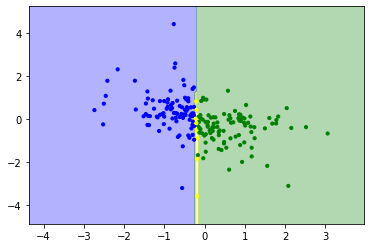

In [35]:
p = svmovr.predict(fore)
plabels = mayprep[:,12]
f = plt.figure()
ax = f.gca() 
ax.scatter(mayprep[:,3],mayprep[:,4], c=p, s=10, cmap=custom_cmap,
                zorder=3)
contours = ax.contourf(xx, yy, Z,
                           levels=np.arange(n_classes + 1) - 0.5, alpha=0.3,
                           cmap=custom_cmap, 
                           zorder=1)

Calculate the confusion matrix and print.

In [26]:
c=confusion_matrix(plabels, p)
print(c)
57/(57+1+31)
57/58

[[57  0  1]
 [ 1 68  0]
 [31 27 11]]


0.9827586206896551

diagonal elements: truely predicted
off-diagonal: False
categroy 3: some wrong predictions


cat1: one is actually catt 1 but has been categorized as cat 3

caat 3: 11 correct --> small regiojn, miss-categorized

## Tasks
Once you have achieved the best results on the validation data.
- Read in the dataset jun20.out 
- Check your prediction on this new dataset
- Calculate the precision and recall for each category